In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import glob
import pickle
import pandas as pd

In [3]:
import sys
sys.path.append('../..')
from loaders import load_sabes

In [4]:
dpath = '/media/akumar/Secondary/data/sabes'

In [5]:
dfiles = glob.glob('%s/*.mat' % dpath)

In [10]:
dat = load_sabes(dfiles[0], 50, 0.5, 'none', {}, 100, std_behavior=False)

In [6]:
start_times = {'indy_20160426_0': 0, 
               'indy_20160622_01':1700, 
               'indy_20160624_03': 500, 
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }

In [8]:
plt.plot(dat['behavior'][0:3000, 0])
plt.plot(dat['behavior'][0:3000, 1])

NameError: name 'dat' is not defined

#### For this particular data file, motion seems to begin at 1600

In [7]:
target_locs = []
time_on_target = []
valid_transition_times = []

target_diff = np.diff(dat['target_pos'].T)
# This will yield the last index before the transition
transition_times = np.sort(np.unique(target_diff.nonzero()[1]))
#transition_times = target_diff.nonzero()[1]

# For each transition, make a record of the location, time on target, and transition_vector
# Throw away those targets that only appear for 1 timestep
for i, transition_time in enumerate(transition_times):

    # Only lingers at the target for one timestep
    if i < len(transition_times) - 1:
        if np.diff(transition_times)[i] == 1:
            continue

    target_locs.append(dat['target_pos'][transition_time][:])
    valid_transition_times.append(transition_time)
    
for i, transition_time in enumerate(valid_transition_times):
        
    if i == 0:
        time_on_target.append(transition_time + 1)
    else:
        time_on_target.append(transition_time - valid_transition_times[i - 1] + 1)
        
target_locs = np.array(target_locs)
time_on_target = np.array(time_on_target)
valid_transition_times = np.array(valid_transition_times)

# Filter out by when motion starts

# Reference target target
init_target_loc = target_locs[valid_transition_times < 1600][-1]
target_locs = target_locs[valid_transition_times > 1600]
time_on_target = time_on_target[valid_transition_times > 1600]
valid_transition_times = valid_transition_times[valid_transition_times > 1600]

In [8]:
# Assess how close the cursor gets to each target location

In [9]:
# successful reaches require low target error at the initial and final point.

In [8]:
# Velocity profiles
vel = np.diff(dat['behavior'], axis=0)

In [9]:
target_pairs = []
for i in range(1, len(target_locs)):
    target_pairs.append((i - 1, i))

In [10]:
target_error_pairs = np.zeros(len(target_pairs))
for i in range(len(target_pairs)):
    
#    time_win = max(min(10, int(0.05 * time_on_target[i])), 2)
    time_win = 2
    
    # Length of time_win just after target switches
    cursor_0 = dat['behavior'][valid_transition_times[target_pairs[i][0]] + 1:\
                               valid_transition_times[target_pairs[i][0]] + 1 + time_win]
    # Length of time_win just before target switches again
    cursor_1 = dat['behavior'][valid_transition_times[target_pairs[i][1]] - time_win:\
                               valid_transition_times[target_pairs[i][1]]]

    target_error_pairs[i] = max(np.mean(np.linalg.norm(cursor_0 - target_locs[target_pairs[i][0]])),
                            np.mean(np.linalg.norm(cursor_1 - target_locs[target_pairs[i][1]])))

(array([828.,  41.,  25.,  23.,  24.,  14.,   6.,   5.,   0.,   2.]),
 array([  0.73352263,  19.68516935,  38.63681606,  57.58846278,
         76.54010949,  95.49175621, 114.44340292, 133.39504964,
        152.34669635, 171.29834307, 190.24998978]),
 <BarContainer object of 10 artists>)

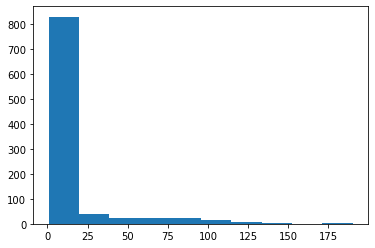

In [11]:
plt.hist(target_error_pairs)

In [12]:
err_thresh = np.quantile(target_error_pairs, 0.9)

In [13]:
# Throw away trajectories with highly erratic velocity profiles
# (large number of zero crossings in the acceleration)

In [14]:
n_zeros = np.zeros(len(target_pairs))
for i in range(len(target_pairs)):
    acc = np.diff(vel[valid_transition_times[target_pairs[i][0]]:\
                      valid_transition_times[target_pairs[i][1]]], axis=0)    
    n_zeros[i] = (np.diff(np.sign(acc)) != 0).sum()

In [15]:
# Throw away reaches with highest 10 % of target error and > 200 acceleration zero crossings
# Pair of target corrdinates
valid_target_pairs = []
# How long did the reach take
reach_duration = []
# Tuple of indices that describes start and end of reach
transition_times = []
transition_vectors = []

for i in range(len(target_error_pairs)):
    
    # Keep this transition
    if target_error_pairs[i] < err_thresh and n_zeros[i] < 200:
        valid_target_pairs.append((target_locs[target_pairs[i][0]], target_locs[target_pairs[i][1]]))        
        reach_duration.append(time_on_target[target_pairs[i][1]])
        transition_times.append((valid_transition_times[target_pairs[i][0]] + 1,
                                 valid_transition_times[target_pairs[i][1]]))
        transition_vectors.append(target_locs[target_pairs[i][1]] - target_locs[target_pairs[i][0]])
    else:
        continue

In [16]:
target_error_pairs = target_error_pairs[np.bitwise_and(target_error_pairs < err_thresh,
                                                       n_zeros < 200)]

In [17]:
# Trialization strategy - first need to calculate velocity sequences 
# Calculate the orientation of target transition vectors relative to a fixed vector. Group together with 
# various coarsenings of the similarity bins of orientation and velocity proifles

In [18]:
transition_orientation = np.zeros(len(transition_vectors))
refvec = np.array([1, 0])
for i in range(len(transition_vectors)):
    # Normalize
    transvecnorm = transition_vectors[i]/np.linalg.norm(transition_vectors[i])
    dot = transvecnorm @ refvec      # dot product
    det = transvecnorm[0]*refvec[1] - transvecnorm[1]*refvec[0]  # determinant
    transition_orientation[i] = np.arctan2(det, dot)

(array([ 63., 137., 142., 162., 116.,  99.,  66.,  41.,  29.,   6.]),
 array([  0.40544247,  19.37147603,  38.33750959,  57.30354316,
         76.26957672,  95.23561028, 114.20164384, 133.1676774 ,
        152.13371096, 171.09974453, 190.06577809]),
 <BarContainer object of 10 artists>)

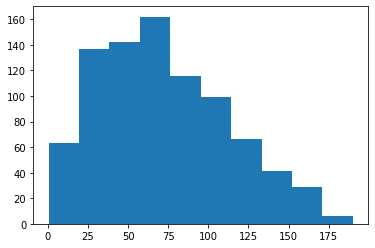

In [19]:
plt.hist(np.linalg.norm(transition_vectors, axis=1))

In [20]:
# Also use the transitionvecnorm

(array([164.,  66.,  43.,  66., 116., 137.,  74.,  49.,  52.,  94.]),
 array([-3.14159265, -2.51545447, -1.88931629, -1.26317811, -0.63703993,
        -0.01090175,  0.61523643,  1.24137461,  1.86751279,  2.49365097,
         3.11978915]),
 <BarContainer object of 10 artists>)

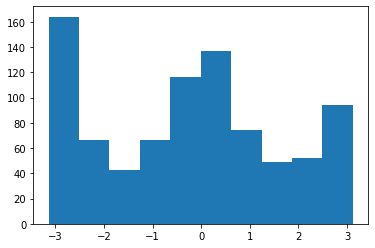

In [21]:
plt.hist(transition_orientation)

In [22]:
# Winding angle

In [23]:
from copy import deepcopy

In [24]:
winding_angle = []
# Operator on a copy of trajectory
cursor_trajectory = deepcopy(dat['behavior'])
dtheta = []
for i in range(len(valid_target_pairs)):
    
    trajectory = cursor_trajectory[transition_times[i][0]:transition_times[i][1], :]
    
    # Translate to the origin
    trajectory -= trajectory[0, :]
    theta = np.arctan2(trajectory[:, 1], trajectory[:, 0]) % (2 * np.pi)
    dtheta.append(np.diff(theta))
    # Integrate
    winding_angle.append(np.sum(np.abs(np.diff(theta))))

In [25]:
# Integrate the area under the trajectory minus the straight line
straight_dev = np.zeros(len(valid_target_pairs))
# Operator on a copy of trajectory
cursor_trajectory = deepcopy(dat['behavior'])
for i in range(len(valid_target_pairs)):
    
    trajectory = cursor_trajectory[transition_times[i][0]:transition_times[i][1], :]

    # Translate to the origin relative to the 1st target location
    trajectory -= valid_target_pairs[i][0]

    # straight line vector
    straight = transition_vectors[i]        
    straight /= np.linalg.norm(straight)

    if straight[0] == 0:
        perp = np.array([1, 0])
    elif straight[1] == 0:
        perp = np.array([0, 1])
    else:
        # Vector orthogonal to the straight line between targets
        x_orth = np.random.uniform(0, 1)
        y_orth = -1 * (straight[0] * x_orth)/straight[1]
        perp = np.array([x_orth, y_orth])
        perp /= np.linalg.norm(perp)
    
    if np.any(np.isnan(perp)):
        pdb.set_trace()
    
#     # This needs to be related to the inner product of the increments with the perp direction
#     trajectory_diff = np.diff(trajectory, axis=0)
#     # Translate to origin
#     straight_dev[i] = np.abs(sum([trajectory_diff[j, :] @ perp 
#                                   for j in range(trajectory_diff.shape[0])]))/\
#                                   sum(np.linalg.norm(trajectory_diff, axis=-1))

    m = straight[1]/straight[0]
    b = 0
        
    for j in range(trajectory.shape[0]):
        
        # transition is horizontal
        if m == 0:
            x_int = trajectory[j, 0]
            y_int = valid_target_pairs[i][0][1]
        # transition is vertical
        elif np.isnan(m) or np.isinf(m):
            x_int = valid_target_pairs[i][0][0]
            y_int = trajectory[j, 1]
        else:
            m1 = -1/m
            b1 = trajectory[j, 1] - m1 * trajectory[j, 0]
            # Find the intersection between the two lines
            x_int = (b - b1)/(m1 - m)
            y_int = m1 * x_int + b1
        
        straight_dev[i] += np.linalg.norm(np.array([x_int - trajectory[j, 0], y_int - trajectory[j, 1]]))
    # Normalize by the length of the straight line trajectory
    straight_dev[i] /= np.linalg.norm(transition_vectors[i])
          
#         # Plot verification
#         if j == 10:
#             if i == 180:
#                 tidx = 180
#                 plt.scatter([0, valid_target_pairs[tidx][1][0] - valid_target_pairs[tidx][0][0]], 
#                 [0, valid_target_pairs[tidx][1][1] - valid_target_pairs[tidx][0][1]])
#                 # trajectory
#                 plt.plot(trajectory[:, 0],
#                          trajectory[:, 1])

#                 # Plot the trajectory difference at each of the 
#                 xmin = min([0, valid_target_pairs[tidx][1][0] - valid_target_pairs[tidx][0][0]])
#                 xmax = max([0, valid_target_pairs[tidx][1][0] - valid_target_pairs[tidx][0][0]])

#                 plt.plot(np.linspace(xmin, xmax), m * np.linspace(xmin, xmax) + b)
            
#                 xmin = min([trajectory[j, 0], x_int])
#                 xmax = max([trajectory[j, 0], x_int])
                
#                 plt.plot(np.linspace(xmin, xmax), m1 * np.linspace(xmin, xmax) + b1)                

#                 # Plot the straight line and the perpendicular line
#                 # plt.plot([0, 10 * straight[0]], [0, 10* straight[1]])
#         #         plt.plot([0, 10 * perp[0]], [0, 10*perp[1]])

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


In [26]:
# Example of successful reaches

In [27]:
err_ordering = np.argsort(target_error_pairs)

In [28]:
xlims = [np.min(dat['target_pos'][:, 0]), np.max(dat['target_pos'][:, 0])]
ylims = [np.min(dat['target_pos'][:, 1]), np.max(dat['target_pos'][:, 1])]

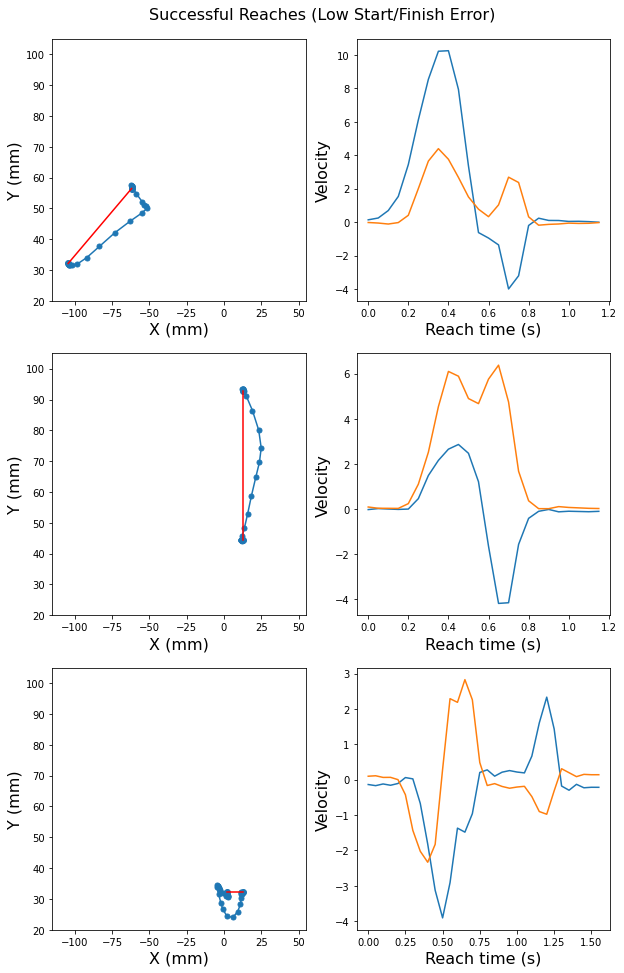

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = err_ordering[i]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
    # Number of zero crossings
    n_zeros = (np.diff(np.sign(acc)) != 0).sum()
#    ax[i, 1].text(0.5, 0.25, '%d' % n_zeros, transform=ax[i, 1].transAxes)
fig.subplots_adjust(top=0.95)
fig.suptitle('Successful Reaches (Low Start/Finish Error)', fontsize=16)
fig.savefig('sabes_segmentation/low_error_example.pdf', bbox_inches='tight', pad_inches=0)

In [294]:
# Examples of unsuccessful reaches

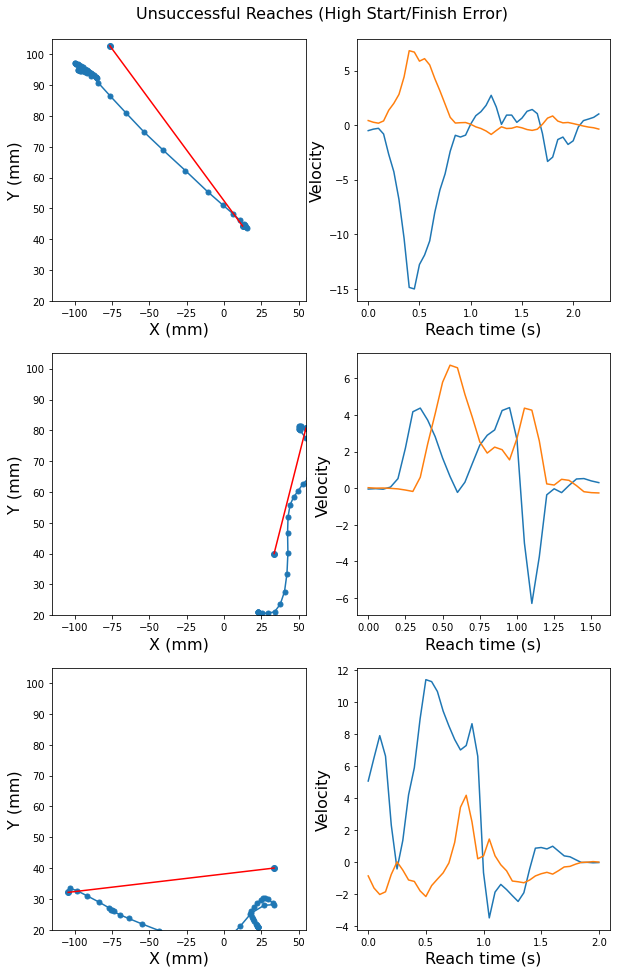

In [67]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = err_ordering[i + 840]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
    # Number of zero crossings
    n_zeros = (np.diff(np.sign(acc)) != 0).sum()
#    ax[i, 1].text(0.5, 0.25, '%d' % n_zeros, transform=ax[i, 1].transAxes)
fig.subplots_adjust(top=0.95)
fig.suptitle('Unsuccessful Reaches (High Start/Finish Error)', fontsize=16)
fig.savefig('sabes_segmentation/high_error_example.pdf', bbox_inches='tight', pad_inches=0)

In [58]:
devorder = np.argsort(straight_dev)

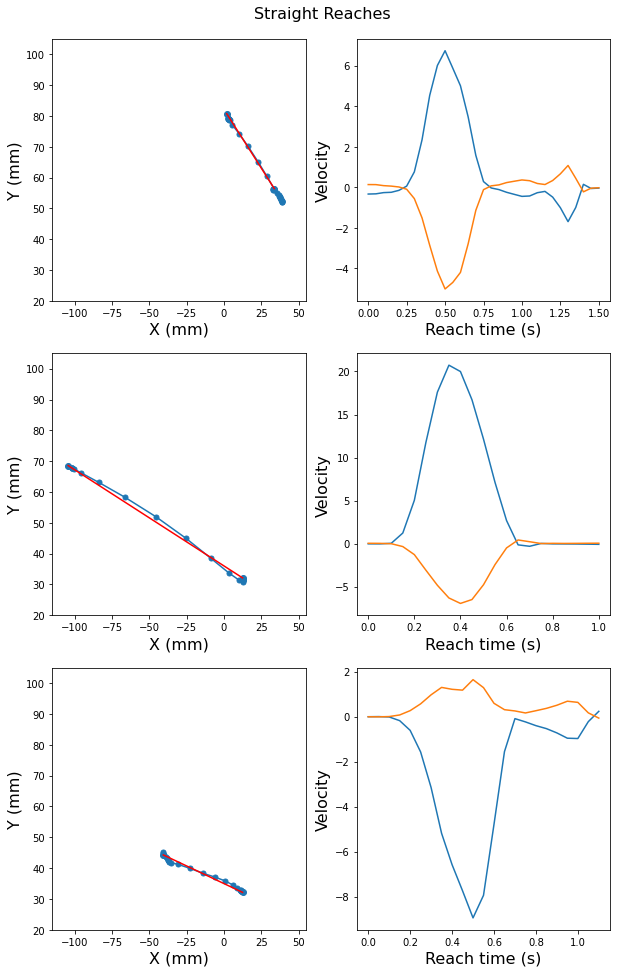

In [70]:
# Example of reaches with large rotational component
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = devorder[i]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
fig.subplots_adjust(top=0.95)
fig.suptitle('Straight Reaches', fontsize=16)
fig.savefig('sabes_segmentation/straight_example.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Joint ordering of reach curvature and target error

In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
straight_dev.shape

(861,)

In [34]:
# We make large deviations small so that we can minimize the sum
straight_dev_normalized = np.squeeze(MinMaxScaler().fit_transform(np.power(straight_dev[:, np.newaxis], -1)))
target_error_normalized = np.squeeze(MinMaxScaler().fit_transform(target_error_pairs[:, np.newaxis]))

In [35]:
combined_obj = straight_dev_normalized + target_error_normalized
combined_order = np.argsort(combined_obj)

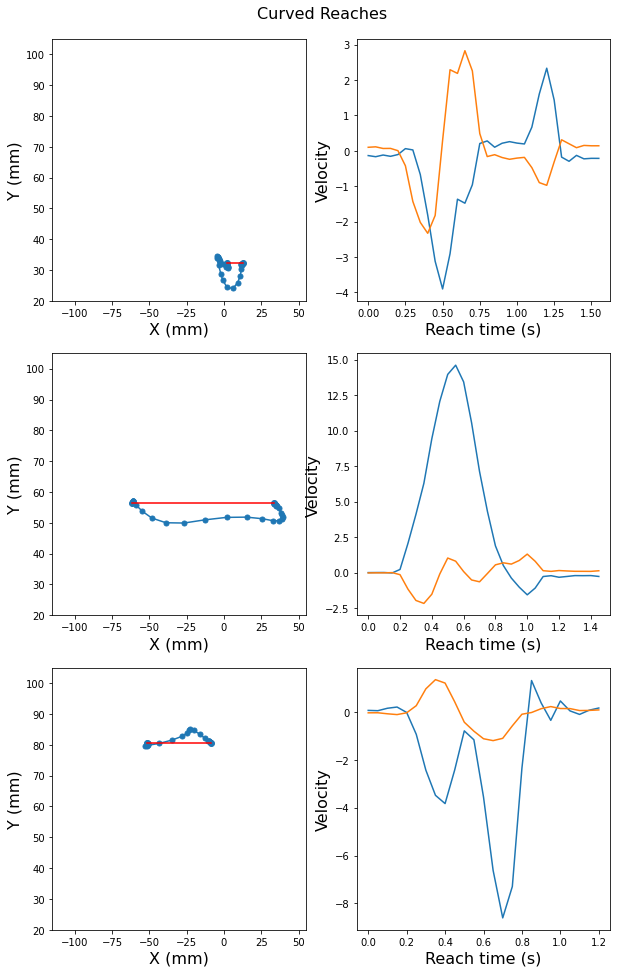

In [82]:
# Example of reaches with large rotational component
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    tidx = combined_order[i]
    # targets
    ax[i, 0].scatter([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]])
    # trajectory
    ax[i, 0].plot(dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 0],
                  dat['behavior'][transition_times[tidx][0]:transition_times[tidx][1], 1], '-o', 
                  markersize=5)
    
    # Annotate with the initial and final error
#     ax[i, 0].text(0.1, 0.9, '%.2f' % target_error_pairs[tidx], transform=ax[i, 0].transAxes)

    # straight line between points
    ax[i, 0].plot([valid_target_pairs[tidx][0][0], valid_target_pairs[tidx][1][0]], 
            [valid_target_pairs[tidx][0][1], valid_target_pairs[tidx][1][1]], 'r')

    ax[i, 0].set_xlim(xlims)
    ax[i, 0].set_ylim(ylims)

    ax[i, 0].set_ylabel('Y (mm)', fontsize=16)
    ax[i, 0].set_xlabel('X (mm)', fontsize=16)
    
    vel_ = vel[transition_times[tidx][0]:transition_times[tidx][1], :]
    acc = np.diff(vel[transition_times[tidx][0]:transition_times[tidx][1], :], axis=0)
    t_ = dat['time'][transition_times[tidx][0]:transition_times[tidx][1]]
    
    #t_ = t_[1:] - t_[0]
    t_ -= t_[0]
    
    ax[i, 1].plot(t_, vel_)
    ax[i, 1].set_ylabel('Velocity', fontsize=16)
    ax[i, 1].set_xlabel('Reach time (s)', fontsize=16)
    
fig.subplots_adjust(top=0.95)
fig.suptitle('Curved Reaches', fontsize=16)
fig.savefig('sabes_segmentation/curved_example.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Features constructed for trialization 
# (1) Reach orientation (transition_orientation)
# (2) Target Reach length np.linalg.norm(transition_vectors, axis=1)
# (3) Perpendicularity of trajectory (straight_dev)
# (4) Nominal reach velocity np.linalg.norm(transition_vectors, axis=1)/reach_duration

### Characterizing reach statistics

In [4]:
from loaders import reach_segment_sabes

In [5]:
data_files = glob.glob('/mnt/Secondary/data/sabes/indy*.mat')
loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

In [6]:
data_files.extend(['/mnt/Secondary/data/sabes/%s' % f for f in loco_files])

In [7]:
lengths = [[] for _ in range(len(data_files))]
orientations = [[] for _ in range(len(data_files))]
durations = [[] for _ in range(len(data_files))]
velocity_peaks = [[] for _ in range(len(data_files))]
acceleration_peaks = [[] for _ in range(len(data_files))]
nvel_pks = [[] for _ in range(len(data_files))]
nacc_pks = [[] for _ in range(len(data_files))]

for j, data_file in enumerate(data_files):
    dat = load_sabes(data_file, 50, 0.5, 'none', {}, 100, std_behavior=False)
    dat = reach_segment_sabes(dat, data_file=data_file.split('.mat')[0].split('/')[-1])
    
    for i, tt in enumerate(dat['transition_times']):
        target_pair= dat['target_pairs'][i]
        length = np.linalg.norm(target_pair[1] - target_pair[0])
        lengths[j].append(length)

        delta = target_pair[1] - target_pair[0]
        theta = np.arctan2(delta[1], delta[0])
        orientations[j].append(theta)
    
        z = dat['behavior'][tt[0]:tt[1]]
        durations[j].append(z.shape[0])

        # Velocity peaks
        vel = np.diff(z, axis=0)
        acc = np.diff(vel, axis=0)

        velnorm = np.linalg.norm(vel, axis=1)
        accnorm = np.linalg.norm(acc, axis=1)

        velocity_peaks[j].append(np.max(velnorm))
        acceleration_peaks[j].append(np.max(accnorm))

        pks, _ = scipy.signal.find_peaks(velnorm/np.max(velnorm), height=0.25, prominence=0.1)
        nvel_pks[j].append(len(pks))
        
        pks, _ = scipy.signal.find_peaks(accnorm/np.max(accnorm), height=0.25, prominence=0.1)
        nacc_pks[j].append(len(pks))

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/notebooks/data_exploration/../../segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


KeyboardInterrupt: 

In [8]:
# with open('reach_statistics.pkl', 'wb') as f:
#     f.write(pickle.dumps({'lengths': lengths,
#                           'orientations': orientations,
#                           'durations': durations,
#                           'velocity_peaks': velocity_peaks,
#                           'acceleration_peaks': acceleration_peaks,
#                           'nvel_pks': nvel_pks,
#                           'nacc_pks': nacc_pks,
#                           'data_files': data_files}))
with open('reach_statistics.pkl', 'rb') as f:
    reach_statistics = pickle.load(f)

lengths = reach_statistics['lengths']
orientations = reach_statistics['orientations']
durations = reach_statistics['durations']
velocity_peaks = reach_statistics['velocity_peaks']
acceleration_peaks = reach_statistics['acceleration_peaks']
nvel_pks = reach_statistics['nvel_pks']
nacc_pks = reach_statistics['nacc_pks']

In [9]:
# Flatten to a single list and calculate the correlations between the statistics
lengths = np.concatenate(lengths)
orientations = np.concatenate(orientations)
durations = np.concatenate(durations)
velocity_peaks = np.concatenate(velocity_peaks)
acceleration_peaks = np.concatenate(acceleration_peaks)
nvel_pks = np.concatenate(nvel_pks)
nacc_pks = np.concatenate(nacc_pks)

In [10]:
# Adjust units
# ms
durations *= 50
# m/s
velocity_peaks *= 50/1000
# m/s^2
acceleration_peaks *= 250/1000

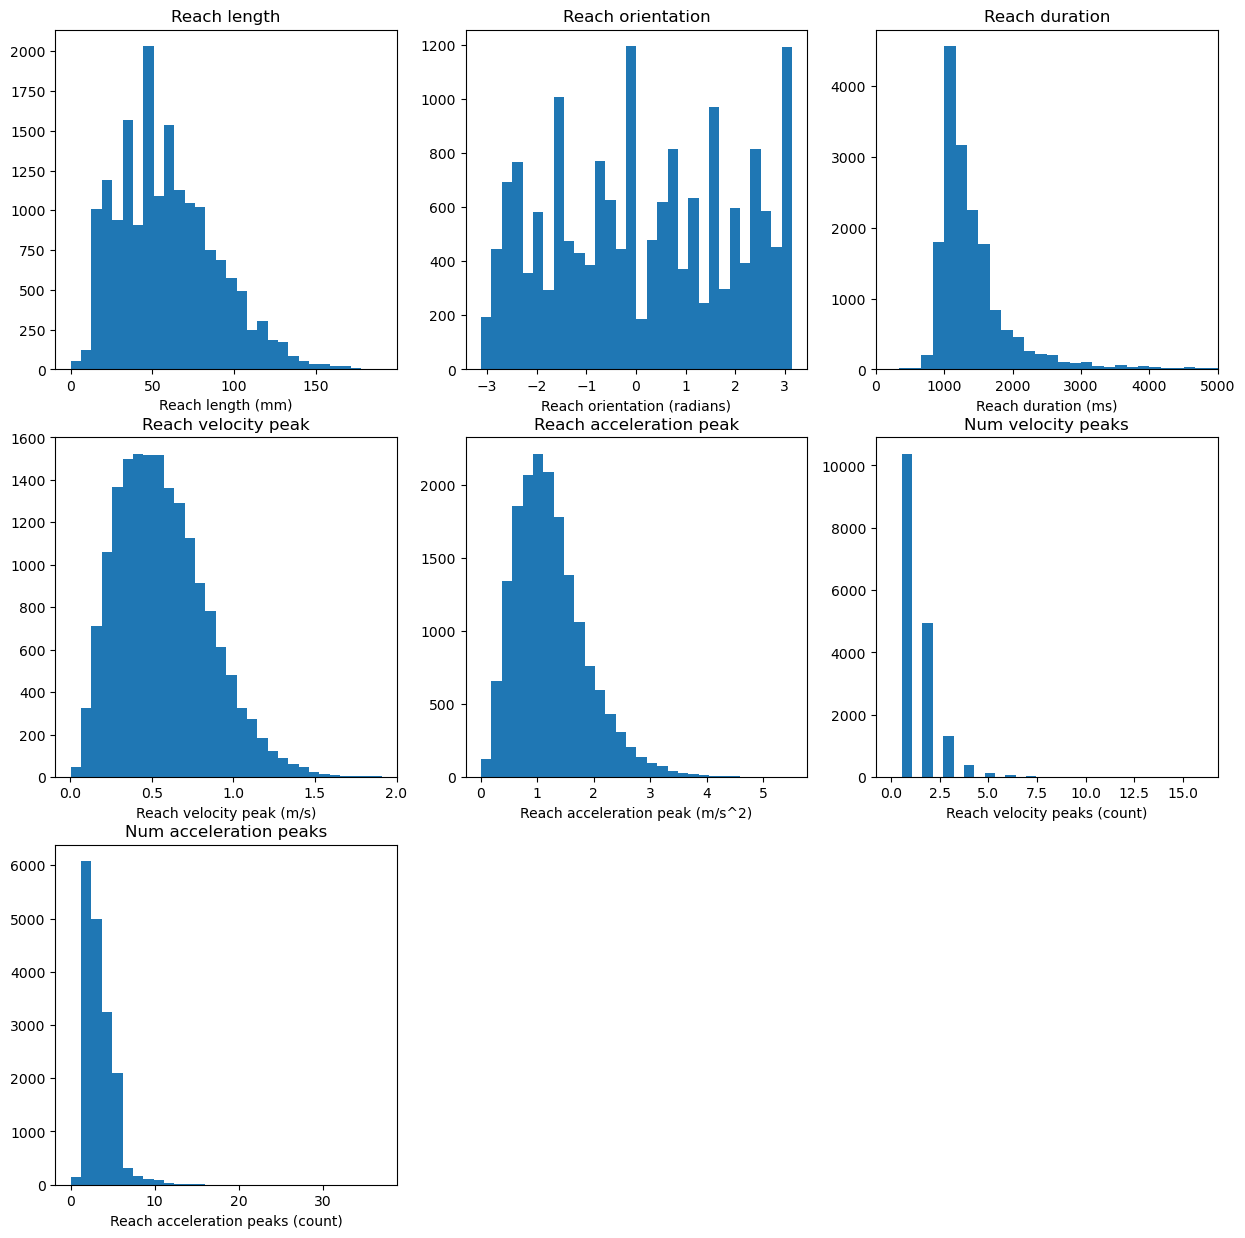

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
stats = [lengths, orientations, durations, velocity_peaks, acceleration_peaks, nvel_pks, nacc_pks]
titles = ['Reach length', 'Reach orientation', 'Reach duration', 'Reach velocity peak', 
          'Reach acceleration peak', 'Num velocity peaks', 'Num acceleration peaks']

for i in range(len(stats)):
    a = ax[np.unravel_index(i, (3, 3))]
    if i == 2:
        a.hist(stats[i], bins=30, range=[0, 5000])
    else:
        a.hist(stats[i], bins=30)
    a.set_title('%s' % titles[i])

# Set units for each of the statistics
ax[np.unravel_index(0, (3, 3))].set_xlabel('Reach length (mm)')
ax[np.unravel_index(1, (3, 3))].set_xlabel('Reach orientation (radians)')
ax[np.unravel_index(2, (3, 3))].set_xlabel('Reach duration (ms)')
ax[np.unravel_index(2, (3, 3))].set_xlim([0, 5000])
ax[np.unravel_index(3, (3, 3))].set_xlabel('Reach velocity peak (m/s)')
ax[np.unravel_index(4, (3, 3))].set_xlabel('Reach acceleration peak (m/s^2)')
ax[np.unravel_index(5, (3, 3))].set_xlabel('Reach velocity peaks (count)')
ax[np.unravel_index(6, (3, 3))].set_xlabel('Reach acceleration peaks (count)') 

# Remove the last subplot
ax[2, 1].axis('off')
ax[2, 2].axis('off')

fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/reach_statistics.pdf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_17497/808292971.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(titles, rotation=45)
/tmp/ipykernel_17497/808292971.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(titles, rotation=45)


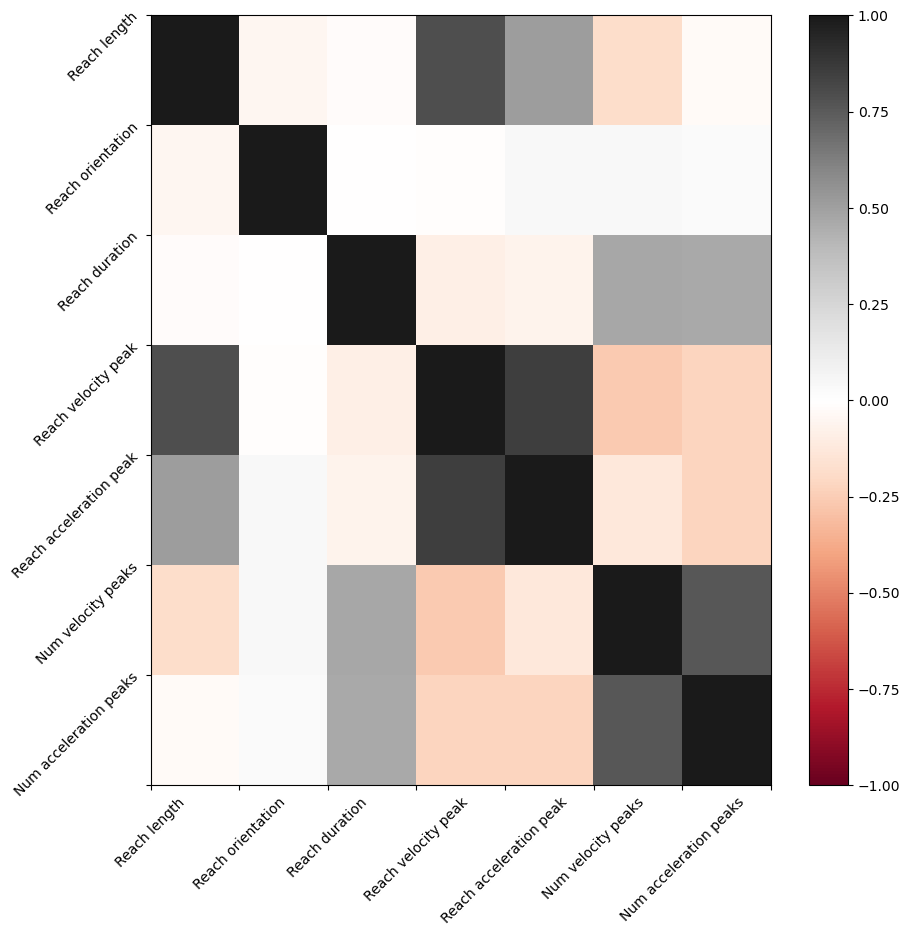

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
corr = np.corrcoef([lengths, orientations, durations, velocity_peaks, acceleration_peaks, nvel_pks, nacc_pks])
ax.pcolor(corr, cmap='RdGy', vmin=-1, vmax=1)
ax.invert_yaxis()

# Add colorbar without resizing the axes
fig.colorbar(ax.collections[0], ax=ax)
ax.set_xticklabels(titles, rotation=45)
ax.set_yticklabels(titles, rotation=45)

fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/reach_statistics_corr.pdf', bbox_inches='tight', pad_inches=0)